## End to end speech recognition

- TIMIT base 
- LSTM and CTC to start

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import numpy as np


## Base de données

In [2]:
import zipfile
import shutil
import gzip
from IPython.display import display, Audio 
import librosa
import datetime
import os 
import pandas as pd
import csv
import pickle as pkl

In [3]:
%%capture

def extract_zip_dir(dir_path, display_info=True):

    with zipfile.ZipFile(dir_path, 'r') as zip_dir:
        
        for member in zip_dir.namelist():
            if os.path.exists('.' + r'/' + member) or os.path.isfile('.' + r'/' + member):
                print(member, 'already exists.')
                pass
            else:
                #zip_dir.printdir()
                zip_dir.extractall()

        if display_info:
            with zipfile.ZipFile(dir_path, 'r') as zip_dir:
                for info in zip_dir.infolist():
                    print(info.filename)
                    print('\tModified:\t' + str(datetime.datetime(*info.date_time)))
                    print('\tSystem:\t\t' + str(info.create_system) + ' (0 = Windows, 3 = Unix)')
                    print('\tZIP version:\t' + str(info.create_version))
                    print('\tCompressed:\t' + str(info.compress_size) + ' bytes')
                    print('\tUncompressed:\t' + str(info.file_size) + ' bytes')


#Write a csv file to manipulate easilier the data
def create_csv_files(word_file_list,
                     txt_csv_file, audio_csv_file):

    word_file_list_df = pd.read_csv(word_file_list, header=None)

    try:

        if not ( os.path.isfile(txt_csv_file) and os.path.isfile(txt_csv_file) ):

            with open(txt_csv_file, 'w', newline='') as txt_file, open(audio_csv_file, 'w', newline='') as audio_file:

                writer_txt   = csv.writer(txt_file)
                writer_audio = csv.writer(audio_file)

                writer_txt.writerow(["index","test_or_train","dialect_region","speaker_id","filename",
                                     "path_from_data_dir",
                                     "is_audio","is_word_file","is_phonetic_file","is_sentence_file"])

                writer_audio.writerow(["index","test_or_train","dialect_region","speaker_id","filename",
                                       "path_from_data_dir",
                                       "is_audio","is_word_file","is_phonetic_file","is_sentence_file"])

                for line in range(len(word_file_list_df)):
                    
                    index = line

                    # Looking for info in the line to fill the CSV
                    line_str = word_file_list_df.iloc[line][0]

                    if "TEST" in line_str:
                        test_or_train = "TEST"
                    else:
                        test_or_train = "TRAIN"
                    dialect_region    = "DR" + line_str[line_str.find("/DR") + 3]
                    speaker_id        = line_str[line_str.find(dialect_region) + 4 : line_str.find(dialect_region) + 9]
                    file_name         = line_str[line_str.find(speaker_id) + 6 :]
                    # Remove suffix WRD from the name to replace it by TXT
                    if ".WRD" in file_name:
                        file_name = file_name.replace(".WRD", "")

                    txt_file_name     = file_name + ".TXT.gz"
                    audio_file_name   = file_name + ".WAV.gz"

                    path_from_data_dir_txt   = "./TIMIT/" + test_or_train + "/" + dialect_region + "/" + speaker_id + "/" + txt_file_name 
                    path_from_data_dir_audio = "./TIMIT/" + test_or_train + "/" + dialect_region + "/" + speaker_id + "/" + audio_file_name
                    
                    writer_txt.writerow([index, test_or_train, dialect_region, speaker_id, file_name, path_from_data_dir_txt, 
                                         False, False, False, True])
                    writer_audio.writerow([index, test_or_train, dialect_region, speaker_id, audio_file_name, path_from_data_dir_audio,
                                           True, False, False, False])
            
        else: 
            print("CSV files already exist")

    except IOError as err:
        print ('Failed to open csv files:', err.strerror)
        

def extract_gzip_files(path_to_files):

    files_df = pd.read_csv(path_to_files)

    # Case where we extract audio files
    if ".WAV.gz" in files_df["path_from_data_dir"].iloc[0]:
        
        for path in files_df["path_from_data_dir"]:

            with gzip.open(path, 'rb') as f_in:
                with open(path.replace("WAV.gz", "wav"), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    
    # Case where we extract txt files
    elif ".TXT.gz" in files_df["path_from_data_dir"].iloc[0]:

        for path in files_df["path_from_data_dir"]:

            with gzip.open(path, 'rb') as f_in:
                with open(path.replace("TXT.gz", "txt"), 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)


if __name__=='__main__':

    dir_path = "TIMIT.zip"
    extract_zip_dir(dir_path, display_info=False)

    # create fill CSV files
    word_file_path = "TIMIT/word_files.txt.gz"
    audio_csv_path = "TIMIT/audio_data.csv"
    txt_csv_path   = "TIMIT/txt_data.csv"

    create_csv_files(word_file_path, txt_csv_path, audio_csv_path)

    # extract needed gz files
    extract_gzip_files(audio_csv_path)
    extract_gzip_files(txt_csv_path)

In [4]:
def create_data_frame(csv_path):

    dataframe = pd.read_csv(csv_path)

    if "WAV.gz" in dataframe["path_from_data_dir"].iloc[0]:
        dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"].str.replace("WAV.gz", "wav", regex=True)

    if "TXT.gz" in dataframe["path_from_data_dir"].iloc[0]:
        dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"] = dataframe["path_from_data_dir"].str.replace("TXT.gz", "txt", regex=True)

    return dataframe


if __name__=="__main__":

    audio_csv_path = "TIMIT/audio_data.csv"
    txt_csv_path   = "TIMIT/txt_data.csv"

    audio_df = create_data_frame(audio_csv_path)
    txt_df   = create_data_frame(txt_csv_path)

In [5]:
def display_samples_time_distrib(dataframe_of_interest):

    train_duration_list = []
    test_duration_list  = []

    for type in ["TRAIN", "TEST"]:
        for path in dataframe_of_interest["path_from_data_dir"][(dataframe_of_interest["test_or_train"]==type)]:

            if type == "TRAIN":
                audio, sample_rate = librosa.load(path)
                train_duration_list.append(audio.shape[0])
            else:
                test_duration_list.append(audio.shape[0])

    train_duration_list.sort()
    test_duration_list.sort()
            
    return train_duration_list, test_duration_list

if __name__ == "__main__":

    audio_train_duration_list_path = "audio_train_duration_list.pkl"
    audio_test_duration_list_path  = "audio_test_duration_list.pkl"

    if not ( os.path.isfile(audio_train_duration_list_path) and os.path.isfile(audio_test_duration_list_path) ):

        audio_train_duration_list, audio_test_duration_list = display_samples_time_distrib(audio_df)

        with open(audio_train_duration_list_path, "wb") as file_train, open(audio_test_duration_list_path, "wb") as file_test:
            pkl.dump(audio_train_duration_list, file_train)
            pkl.dump(audio_test_duration_list, file_test)
        

    else:
        print(f'Files {audio_train_duration_list_path} and {audio_test_duration_list_path} already exist')

        with open(audio_train_duration_list_path, "rb") as file_train, open(audio_test_duration_list_path, "rb") as file_test:
            audio_train_duration_list = pkl.load(file_train)
            audio_test_duration_list  = pkl.load(file_test)

Files audio_train_duration_list.pkl and audio_test_duration_list.pkl already exist


Mean train:	 67740.16774891775
Std train:	 18986.145148907053
Mean test:	 59836.0
Std test:	 0.0


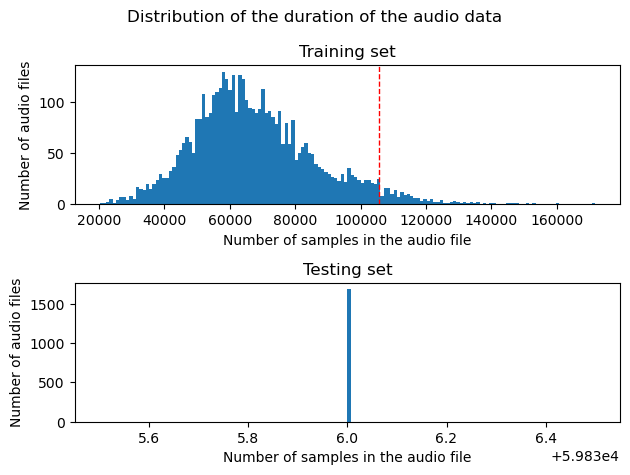

In [6]:
# Plotting time distib of samples in the database

# Stastistic info
mean_train = np.mean(audio_train_duration_list)
mean_test  = np.mean(audio_test_duration_list)
std_train = np.std(audio_train_duration_list)
std_test  = np.std(audio_test_duration_list)

print(f'Mean train:\t {mean_train}\nStd train:\t {std_train}')
print(f'Mean test:\t {mean_test}\nStd test:\t {std_test}')

#print(audio_test_duration_list)

fig, axs = plt.subplots(2)

axs[0].hist(audio_train_duration_list, bins=150)
axs[0].set_title("Training set")
axs[0].set_xlabel("Number of samples in the audio file")
axs[0].set_ylabel("Number of audio files")
# For the training set, we will truncate at 2 std from the mean all the audio samples which duration 
# is superior to the mean and pad to the choosen length the others
axs[0].axvline(mean_train + 2*std_train, color='r', linestyle='dashed', linewidth=1)


axs[1].hist(audio_test_duration_list, bins=150)
axs[1].set_title("Testing set")
axs[1].set_xlabel("Number of samples in the audio file")
axs[1].set_ylabel("Number of audio files")

fig.suptitle("Distribution of the duration of the audio data")

fig.tight_layout()
plt.show()

In [7]:
def trunc_pad_audio_data(audio_file, truncate_val):

    # truncating
    if audio_file.shape[0] > truncate_val and truncate_val != 0:
        new_audio_file = audio_file[0:truncate_val]

    # padding
    elif audio_file.shape[0] < truncate_val:
        new_audio_file = np.concatenate((audio_file, np.zeros(truncate_val - audio_file.shape[0])), axis=None)

    else:
        return audio_file

    return new_audio_file

In [8]:
import pickle as pkl

def fill_X_and_y(list_type, vocabulary_list, truncate_val=0):
    """
        type (str): "TRAIN" or "TEST"
    """

    X = []
    y = []

    for path in audio_df["path_from_data_dir"][(audio_df["test_or_train"]==list_type)]:

        # fill X
        audio, sample_rate = librosa.load(path)

        # trunc or pad the audio file
        trunc_audio = trunc_pad_audio_data(audio, truncate_val)

        # hop length is set as in the cited paper
        mfcc_spectrogram   = librosa.feature.mfcc(y=trunc_audio, sr=sample_rate, n_fft=254, hop_length=254-128, n_mels=13)

        #print(mfcc_spectrogram.shape)
        X.append(mfcc_spectrogram)

        # fill y
        path = path.replace("wav", "txt")
        text = open(path, 'r').read()
        # symbolic encoding of y
        text = y_layout(text, vocabulary_list)
        y.append(text)

    return X, y

def y_layout(text, vocabulary_list):

    # withdraw the numbers at the beginning
    text = text.split(" ")
    text = text[2:]
    text = " ".join(text)

    # encode in choosen vocabulary adapted to the task of the Neural Network
    clean_text = ''.join([char for char in text if char in vocabulary_list])

    # split all string separately 
    clean_text = list(clean_text)
    # to numpy array
    y = np.array(clean_text)

    return y


def save_datasets(X, y, file_name):

    with open(file_name, "wb") as file:
        pkl.dump([X, y], file)


def load_datasets(file_name):

    with open(file_name, "rb") as file:
        X, y = pkl.load(file)

    return X, y



if __name__=="__main__":

    vocabulary = [chr(i) for i in range(32, 35)] + [chr(i) for i in range(39, 41)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)] + [",", ".", ":", ";", "?"]
    # Print vocabulary list
    print(vocabulary)

    #Statistic info
    mean_train = np.mean(audio_train_duration_list)
    mean_test  = np.mean(audio_test_duration_list)
    std_train = np.std(audio_train_duration_list)
    std_test  = np.std(audio_test_duration_list)

    if not os.path.isfile("trunc_pad_train.pkl"):

        X_train, y_train = fill_X_and_y(list_type="TRAIN",vocabulary_list=vocabulary, truncate_val=int(mean_train + 2*std_train))
        file_name = "trunc_pad_train.pkl"
        save_datasets(X_train, y_train, file_name)
        
    else:
        print("Train file already exist")

    if not os.path.isfile("trunc_pad_test.pkl"):

        file_name = "trunc_pad_test.pkl"
        # no need trucating audio files in X_test because all at same length
        X_test, y_test   = fill_X_and_y(list_type="TEST", vocabulary_list=vocabulary)
        save_datasets(X_test, y_test, file_name)

    else: print("Test file already exist")


[' ', '!', '"', "'", '(', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ',', '.', ':', ';', '?']
Train file already exist
Test file already exist


In [9]:
file_name = "trunc_pad_train.pkl"
X_train, y_train = load_datasets(file_name)
file_name = "trunc_pad_test.pkl"
X_test, y_test   = load_datasets(file_name)

In [10]:
print(f'Are labels in train and test datasets the same?\t {y_test == y_train}')

print(f'Shape of X_train items:\t\t\t {X_train[0].shape}')
print(f'Shape of X_test items:\t\t\t {X_test[0].shape}')

max_len_y_test = max([len(y_test[i]) for i in range(len(y_test))])
print(f'Maximum length of y_test labels:\t {max_len_y_test}')
max_len_y_train = max([len(y_train[i]) for i in range(len(y_train))])
print(f'Maximum length of y_train labels:\t {max_len_y_train}')

Are labels in train and test datasets the same?	 False
Shape of X_train items:			 (13, 839)
Shape of X_test items:			 (13, 695)
Maximum length of y_test labels:	 80
Maximum length of y_train labels:	 80


## Modèle

In [11]:
class lstms_layer(nn.Module):

    def __init__(self, input_layer, hidden_size=256, output_layer=100):
        super().__init__() 

        self.lstm0 = nn.LSTM(input_size=input_layer, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size=input_layer, hidden_size=hidden_size // 2, num_layers=1,  bidirectional=True, batch_first=True)

        self.lin_layer  = nn.Sequential(nn.Linear(in_features=hidden_size, out_features=output_layer),
                                        nn.ReLU() 
                                        )

    def forward(self, x):

        x1, _ = self.lstm0(x)
        
        x2, _ = self.lstm1(x)

        x_out = torch.concat([x1, x2], dim=1)
        x_out = self.lin_layer(x_out[:,-1,:])

        #Missing the CTC loss

        return x

## Utils

In [12]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, file_path, device):
    state_params = torch.load(file_path)
    model.load_state_dict(state_params)

def train_epoch():
    raise NotImplemented

def valid_epoch():
    raise NotImplemented

def training_function():
    raise NotImplemented

def save_checkpoint_model():
    raise NotImplemented

def load_checkpoint_model():
    raise NotImplemented

def plot_results():
    plt.show()
    raise NotImplemented

## Main

In [13]:
from torchsummary import summary

In [15]:
if __name__=="__main__":

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model
    input_layer  = X_train[0].shape[1] #839
    hidden_size  = 256
    output_layer = 85
    model = lstms_layer(input_layer, hidden_size, output_layer)

    summary(model, (13, 839))

    # Loss function
    #transcription_lengths = torch.full((batch_size,), transcription_length, dtype=torch.long)
    #audio_lengths = torch.full((batch_size,), audio_length, dtype=torch.long)
    #loss = self.ctc_loss(outputs.log_softmax(2), transcription, transcription_lengths, audio_lengths)

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 13, 256]             1,123,328
├─LSTM: 1-2                              [-1, 13, 256]             992,256
├─Sequential: 1-3                        [-1, 85]                  --
|    └─Linear: 2-1                       [-1, 85]                  21,845
|    └─ReLU: 2-2                         [-1, 85]                  --
Total params: 2,137,429
Trainable params: 2,137,429
Non-trainable params: 0
Total mult-adds (M): 2.16
Input size (MB): 0.04
Forward/backward pass size (MB): 0.05
Params size (MB): 8.15
Estimated Total Size (MB): 8.25
